In [1]:
import os
import sys
from tqdm.notebook import tqdm
from IPython.display import clear_output

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [2]:
from MatSamp import *
import matplotlib.pyplot as plt
import igraph as ig
import networkx as nx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle

plt.rcParams.update(
    {"text.usetex": True, "font.family": "STIXGeneral", "mathtext.fontset": "stix"}
)

visual_style = {
    "vertex_size": 5,
    "vertex_color": "white",
    "vertex_frame_width": 1,
    "edge_width": 0.5,
    "bbox": (400, 400),  # Size of the plot canvas
    "margin": 20,
    "vertex_label_color": "black",
}

In [3]:
n = 128
p = np.round(1.2 * np.log(n) / n, 2)
#print(n, p)
net = ig.Graph.Erdos_Renyi(n=n, p=p)
#net = ig.Graph.K_Regular(n=n, k=4)

0.04851875826716423 (1984, 27) 121107


Text(0.5, 1.0, 'r=0.05')

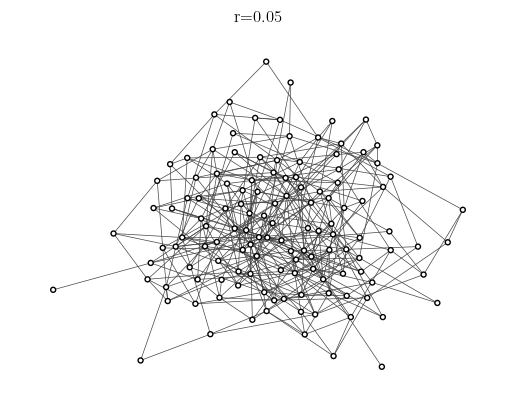

In [4]:
A = ig_to_A(net)
SNet = MatSamp(A, False)

deg = SNet.deg
n = SNet.n

motif_list = [(3, 2), (3, 3)]
org_r, org_motif, org_checker = (
    SNet.assortativity_coeff(),
    SNet.count_motif(),
    SNet.count_checker(),
)
print(org_r, org_motif, np.sum(org_checker))

fig, ax = plt.subplots()
ig.plot(net, target=ax, **visual_style)
ax.set_title(r"r={:.2f}".format(net.assortativity_degree(directed=False)))

In [12]:
A = ig_to_A(net)
SNet = MatSamp(A, False)

In [13]:
np.random.seed(1)
random.seed(1)

34.24134765625058
100 bins
100


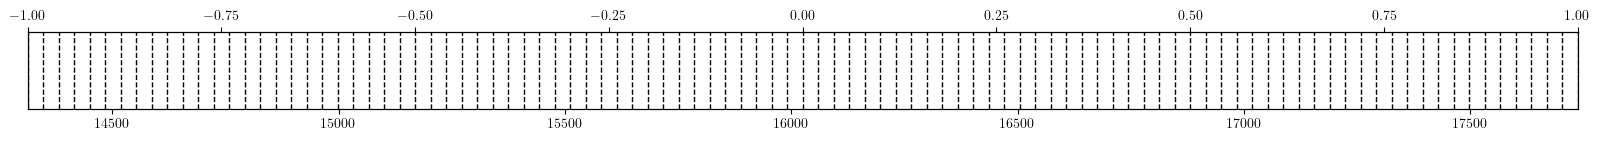

In [14]:
steps = (2 * SNet.M3 - 2 * SNet.M1)

bin_cnt = int(min(100,steps))

bins_edge = np.linspace(-SNet.M3 + 2 * SNet.M1, SNet.M3, bin_cnt+1)

bins_center = (bins_edge[1:] + bins_edge[:-1])/2

print(bins_edge[1]-bins_edge[0])
bin_cnt = len(bins_edge) - 1
print(
    "{:d} bins".format(
        bin_cnt
    )
)

fig, ax = plt.subplots(figsize=(20, 1))
ax.set_yticks([])
for x in bins_edge:
    ax.axvline(x=x, color="k", linestyle="--", linewidth=1)
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xlim([-SNet.M3 + 2 * SNet.M1, SNet.M3])
ax2 = ax.twiny()
ax2.set_xlim([-1, 1])
print(bin_cnt)

In [15]:
# def random_edgeswap(SNet, bins_center, S):
#     swt = SNet.next("rand")
#     M2cur = SNet.M2
#     M2nxt = SNet.M2_after_swt(swt)
#     curidx = np.searchsorted(bins_center, M2cur, side="right") - 1
#     nxtidx = np.searchsorted(bins_center, M2nxt, side="right") - 1

#     Scur = S[curidx] + (S[curidx + 1] - S[curidx]) * (M2cur - bins_center[curidx]) / (
#         bins_center[curidx + 1] - bins_center[curidx]
#     )

#     Snxt = S[nxtidx] + (S[nxtidx + 1] - S[nxtidx]) * (M2nxt - bins_center[nxtidx]) / (
#         bins_center[nxtidx + 1] - bins_center[nxtidx]
#     )

#     if np.log(np.random.rand()) < Scur - Snxt:
#         SNet.switch(swt)


# def random_checkerboard(SNet, bins_center, S):
#     CBcur = SNet.count_checker()

#     if CBcur[0] == 0:
#         posswt = False
#     elif CBcur[1] == 0:
#         posswt = True
#     else:
#         posswt = np.random.rand() > 0.5

#     swt = find_random_checker(SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, posswt)

#     M2cur = SNet.M2
#     SNet.switch(swt)
#     CBnxt = SNet.count_checker()
#     M2nxt = SNet.M2

#     curidx = np.searchsorted(bins_center, M2cur, side="right") - 1
#     nxtidx = np.searchsorted(bins_center, M2nxt, side="right") - 1
#     Scur = S[curidx] + (S[curidx + 1] - S[curidx]) * (M2cur - bins_center[curidx]) / (
#         bins_center[curidx + 1] - bins_center[curidx]
#     )

#     Snxt = S[nxtidx] + (S[nxtidx + 1] - S[nxtidx]) * (M2nxt - bins_center[nxtidx]) / (
#         bins_center[nxtidx + 1] - bins_center[nxtidx]
#     )

#     gcur = np.log(1 / CBcur[0] if posswt else 1 / CBcur[1])
#     gnxt = np.log(1 / CBnxt[1] if posswt else 1 / CBnxt[0])

#     if np.log(np.random.rand()) > Scur - Snxt + gnxt - gcur:
#         SNet.switch(swt)

In [16]:
def get_random_switch_p(r,left,right,epsilon):
    if r < (left + right):
        random_swt_prob = (r + epsilon - left) / (2 * epsilon)
    else:
        random_swt_prob = (-r + epsilon + right) / (2 * epsilon)

    return np.clip(random_swt_prob, 0, 1)

In [18]:
SNet.trackCheckerboard = True
rmin, rmax = 1, -1
for i in tqdm(range(10)):
    while SNet.count_checker()[0] > 0:
        swt = find_random_checker(
            SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, True
        )
        SNet.switch(swt)
        rmin, rmax = min(rmin, SNet.assortativity_coeff()), max(
            rmax, SNet.assortativity_coeff()
        )
    while SNet.count_checker()[1] > 0:
        swt = find_random_checker(
            SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, False
        )
        SNet.switch(swt)
        rmin, rmax = min(rmin, SNet.assortativity_coeff()), max(
            rmax, SNet.assortativity_coeff()
        )
print(rmin, rmax)

  0%|          | 0/10 [00:00<?, ?it/s]

-0.9648759365081787 0.932245671749115


In [22]:
H_star = {}
H = {}
S = np.zeros(bin_cnt)
cnt = 0
tunnel = 0
tunnelFlag = -1
tunnelCnt = 10
finit = 10#np.exp(0)
ffinal = 1e-5
f = finit
tunnel_threshold = 5
step = 0

deg = SNet.deg
# print(deg)
epsilon_M2 = max((deg[0]-deg[-1])*(deg[1]-deg[-2]),(deg[1]-deg[-1])*(deg[0]-deg[-2]))
epsilon_r = epsilon_M2 / (SNet.M3 - SNet.M1)
#print(epsilon_M2)
#print(epsilon_r)

In [23]:
# band_left_r, band_right_r = 0,0#-1,1#0.1, 0.1
# band_left_M2, band_right_M2 = (
#     band_left_r * (SNet.M3 - SNet.M1) + SNet.M1,
#     band_right_r * (SNet.M3 - SNet.M1) + SNet.M1,
# )

# print(band_left_M2, band_right_M2)

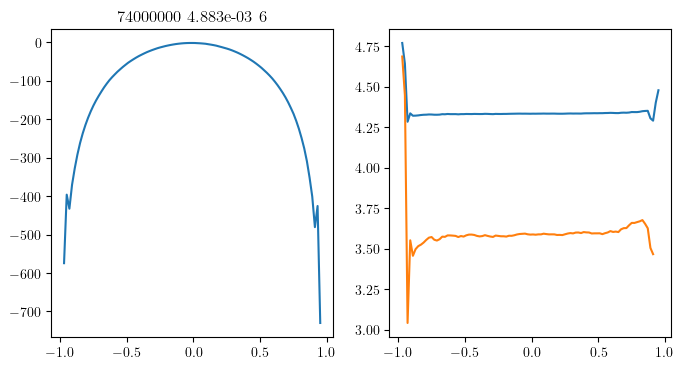

In [ ]:
pbar = tqdm(initial=tunnel, total=tunnelCnt)
SNet.trackCheckerboard = True


while f > ffinal:
    cnt += 1

    CBcur = SNet.count_checker()
    if CBcur[0] == 0:
        p = 1
        posswt = False
    elif CBcur[1] == 0:
        p = 1
        posswt = True
    else:
        p = 0.5
        posswt = np.random.rand() > 0.5

    swt = find_random_checker(
        SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, posswt
    )

    if swt[0] != -1:

        M2cur = SNet.M2
        SNet.switch(swt)
        CBnxt = SNet.count_checker()
        M2nxt = SNet.M2

        gcur = np.log(p * (1 / CBcur[0] if posswt else 1 / CBcur[1]))
        gnxt = np.log(p * (1 / CBnxt[1] if posswt else 1 / CBnxt[0]))

        curidx = np.searchsorted(bins_center, M2cur, side="right") - 1
        nxtidx = np.searchsorted(bins_center, M2nxt, side="right") - 1
        Scur = S[curidx] + (S[curidx + 1] - S[curidx]) * (
            M2cur - bins_center[curidx]
        ) / (bins_center[curidx + 1] - bins_center[curidx])

        Snxt = S[nxtidx] + (S[nxtidx + 1] - S[nxtidx]) * (
            M2nxt - bins_center[nxtidx]
        ) / (bins_center[nxtidx + 1] - bins_center[nxtidx])

        # switch back
        if np.log(np.random.rand()) > Scur - Snxt + gnxt - gcur:
            SNet.switch(swt)

    bin_idx = np.searchsorted(bins_edge, SNet.M2, side="right") - 1
    if not (bin_idx in H):
        H[bin_idx] = 0
    if not (bin_idx in H_star):
        H_star[bin_idx] = 0

    H[bin_idx] += 1
    H_star[bin_idx] += 1
    S[bin_idx] += f / (bins_edge[bin_idx + 1] - bins_edge[bin_idx])

    bmin = min(H_star)
    bmax = max(H_star)
    # print(bmax)
    # print(bmax - (bin_cnt) * tunnel_threshold / 100)
    if (
        tunnelFlag == -1
        and bin_idx >= bmax - (bmax - bmin) * tunnel_threshold / 100
        and SNet.assortativity_coeff() >= rmax - (rmax - rmin) * tunnel_threshold / 100
    ):

        tunnel += 1
        pbar.update(1)
        tunnelFlag = 1

    elif (
        tunnelFlag == 1
        and bin_idx <= bmin + (bmax - bmin) * tunnel_threshold / 100
        and SNet.assortativity_coeff() <= rmin + (rmax - rmin) * tunnel_threshold / 100
    ):
        tunnelFlag = -1

    if tunnel >= tunnelCnt:
        print(
            "{:2d} {:10d} {:10.5e} {:1d}".format(step, cnt, f, tunnel),
        )
        pbar = tqdm(total=tunnelCnt)
        tunnel = 0
        tunnelFlag = -1
        if f / 2 > ffinal:
            H = {}
        f = f / 2
        step += 1
    # print(SNet.assortativity_coeff())
    if cnt % 1000000 == 0:
        clear_output(wait=True)
        mx = np.max(S)
        S_sum = mx + np.log(np.sum(np.exp(S - mx)))
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].plot(
            (bins_center[S != 0] - SNet.M1) / (SNet.M3 - SNet.M1), (S - S_sum)[S != 0]
        )
        ax[0].set_title(
            "{:d} {:10.3e} {:d}".format(
                cnt, f, tunnel
            )
        )

        data = [(i, j) for i, j in sorted(H_star.items())]
        datax = [(bins_center[i[0]] - SNet.M1) / (SNet.M3 - SNet.M1) for i in data]
        datay = [i[1] / (bins_edge[i[0] + 1] - bins_edge[i[0]]) for i in data]
        ax[1].plot(datax, np.log10(datay))
        data = [(i, j) for i, j in sorted(H.items())]
        datax = [(bins_center[i[0]] - SNet.M1) / (SNet.M3 - SNet.M1) for i in data]
        datay = [i[1] / (bins_edge[i[0] + 1] - bins_edge[i[0]]) for i in data]
        ax[1].plot(datax, np.log10(datay))

        plt.show()
        # pbar = tqdm(initial=tunnel, total=tunnelCnt)


# print(
#     "{:10d} {:10d} {:10d} {:.3f} {:.3f}".format(cnt, bmin,bmax,rmin,rmax ),
# )

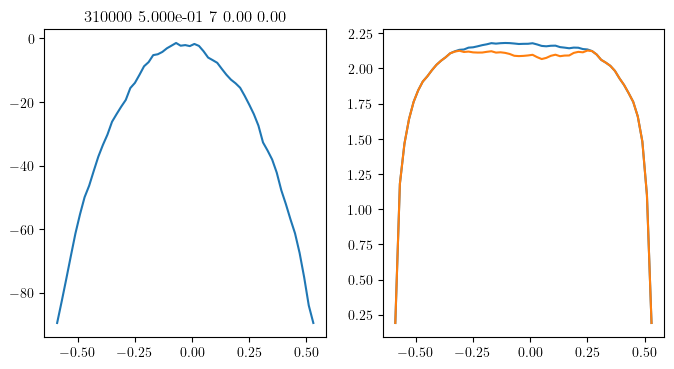

KeyboardInterrupt: 

In [ ]:
# pbar = tqdm(initial = tunnel,total=tunnelCnt)
# SNet.trackCheckerboard = True


# while f > ffinal:
#     cnt+=1

#     cur_p = get_random_switch_p(SNet.assortativity_coeff(),band_left_r,band_right_r,1e-9)
#     # print(SNet.assortativity_coeff(),cur_p)

#     if np.random.rand() < cur_p:
#         swt = SNet.next("rand")
#         i,j,k,l = swt
#         posswt = (i - j) * (k - l) < 0
#         swt_type = 1
#         # random_edgeswap(SNet, bins_center, S)
#     else:
#         CBcur = SNet.count_checker()
#         # if SNet.assortativity_coeff() > band_right_r :
#         #     print(CBcur[0], CBcur[1], SNet.assortativity_coeff())
#         # if CBcur[1] > CBcur[0] and CBcur[0] / CBcur[1] > 1/10:
#         #     band_right_r = max(SNet.assortativity_coeff(),band_right_r)
#         # elif CBcur[0] > CBcur[1] and CBcur[1] / CBcur[0] > 1/10:
#         #    band_left_r = min(SNet.assortativity_coeff(), band_left_r)
#         # print(SNet.assortativity_coeff(),CBcur[0],CBcur[1])
#         # random_checkerboard(SNet, bins_center, S)
#         if CBcur[0] == 0:
#             posswt = False
#         elif CBcur[1] == 0:
#             posswt = True
#         else:
#             posswt = np.random.rand() > 0.5

#         swt = find_random_checker(SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, posswt)

#         swt_type = 2

#     if swt[0] != -1:
#         M2cur = SNet.M2
#         SNet.switch(swt)
#         M2nxt = SNet.M2

#         nxt_p = get_random_switch_p(SNet.assortativity_coeff(),band_left_r,band_right_r,epsilon_r/2)

#         if cur_p == 1 and nxt_p == 1:
#             gcur = gnxt = 0
#         else:   
#             SNet.switch(swt)
#             CBcur = SNet.count_checker()
#             edge_swap_p = SNet.get_swt_prob(swt)
#             # i,j,k,l  = swt
#             # if CBcur[0] == 0 or CBcur[1] == 0:
#             #     print(SNet.A[i, k], SNet.A[i, l])
#             #     print(SNet.A[j, k], SNet.A[j, l])
#             #     print(swt, posswt, swt_type, CBcur[0], CBcur[1])

#             SNet.switch(swt)
#             CBnxt = SNet.count_checker()
#             gcur = np.log(
#                 (1 / CBcur[0] if posswt else 1 / CBcur[1]) * (1 - cur_p)
#                 + cur_p * edge_swap_p
#             )
#             gnxt = np.log(
#                 (1 / CBnxt[1] if posswt else 1 / CBnxt[0]) * (1 - nxt_p)
#                 + nxt_p * edge_swap_p
#             )

#         curidx = np.searchsorted(bins_center, M2cur, side="right") - 1
#         nxtidx = np.searchsorted(bins_center, M2nxt, side="right") - 1
#         Scur = S[curidx] + (S[curidx + 1] - S[curidx]) * (M2cur - bins_center[curidx]) / (
#             bins_center[curidx + 1] - bins_center[curidx]
#         )

#         Snxt = S[nxtidx] + (S[nxtidx + 1] - S[nxtidx]) * (M2nxt - bins_center[nxtidx]) / (
#             bins_center[nxtidx + 1] - bins_center[nxtidx]
#         )

#         # switch back
#         if np.log(np.random.rand()) > Scur - Snxt + gnxt - gcur:
#             SNet.switch(swt)

#     bin_idx = np.searchsorted(bins_edge, SNet.M2, side="right") - 1
#     if not (bin_idx in H):
#         H[bin_idx] = 0
#     if not (bin_idx in H_star):
#         H_star[bin_idx] = 0

#     H[bin_idx] += 1
#     H_star[bin_idx] += 1
#     S[bin_idx] += f / (bins_edge[bin_idx + 1] - bins_edge[bin_idx])

#     bmin = min(H_star)
#     bmax = max(H_star)
#     # print(bmax)
#     # print(bmax - (bin_cnt) * tunnel_threshold / 100)
#     if (
#         tunnelFlag == -1
#         and bin_idx >= bmax - (bmax - bmin) * tunnel_threshold / 100
#         #and SNet.assortativity_coeff() >= 0.5
#     ):

#         tunnel += 1
#         pbar.update(1)
#         tunnelFlag = 1

#     elif (
#         tunnelFlag == 1
#         and bin_idx <= bmin + (bmax - bmin) * tunnel_threshold / 100
#         #and SNet.assortativity_coeff() <= -0.5
#     ):
#         tunnelFlag = -1

#     if tunnel >= tunnelCnt:
#         print(
#             "{:2d} {:10d} {:10.5e} {:1d}".format(step, cnt, f, tunnel),
#         )
#         pbar = tqdm(total=tunnelCnt)
#         tunnel = 0
#         tunnelFlag = -1
#         if f / 2 > ffinal:
#             H = {}
#         f = f / 2
#         step += 1
#     # print(SNet.assortativity_coeff())
#     if cnt % 10000 == 0:
#         clear_output(wait=True)
#         mx = np.max(S)
#         S_sum = mx + np.log(np.sum(np.exp(S - mx)))
#         fig,ax = plt.subplots(1,2,figsize=(8,4))
#         ax[0].plot((bins_center[S != 0] - SNet.M1) / (SNet.M3 - SNet.M1), (S - S_sum)[S != 0])
#         ax[0].set_title(
#             "{:d} {:10.3e} {:d} {:.2f} {:.2f}".format(
#                 cnt, f, tunnel, band_left_r, band_right_r
#             )
#         )

#         data = [(i, j) for i, j in sorted(H_star.items())]
#         datax = [(bins_center[i[0]]-SNet.M1)/(SNet.M3-SNet.M1) for i in data]
#         datay = [i[1] / (bins_edge[i[0] + 1] - bins_edge[i[0]]) for i in data]
#         ax[1].plot(datax, np.log10(datay))
#         data = [(i, j) for i, j in sorted(H.items())]
#         datax = [(bins_center[i[0]] - SNet.M1) / (SNet.M3 - SNet.M1) for i in data]
#         datay = [i[1] / (bins_edge[i[0] + 1] - bins_edge[i[0]]) for i in data]
#         ax[1].plot(datax, np.log10(datay))

#         plt.show()
#         # pbar = tqdm(initial=tunnel, total=tunnelCnt)


# # print(
# #     "{:10d} {:10d} {:10d} {:.3f} {:.3f}".format(cnt, bmin,bmax,rmin,rmax ),
# )

[    0.             0.             0.         92997.14954127
 89596.28116942 89604.54523204 89610.1923415  89614.87531032
 89619.48941195 89625.48085736 89627.68460739 89630.23269337
 89635.05339657 89637.18827941 89640.28730289 89641.4580451
 89643.17972481 89644.90140453 89645.38347485 89647.17402175
 89648.89570146 89648.20702958 89650.54851399 89650.34191242
 89650.61738118 89652.20132651 89651.99472495 89653.02773278
 89654.88714687 89655.23148281 89656.4710922  89657.29749846
 89657.29749846 89657.43523284 89658.12390473 89658.19277192
 89659.01917818 89658.74370942 89659.15691256 89659.84558444
 89659.15691256 89659.98331882 89660.39652195 89659.57011569
 89660.6719907  89660.18992038 89659.98331882 89660.25878757
 89660.18992038 89660.74085789 89661.22292821 89659.63898288
 89661.01632665 89660.53425633 89659.08804537 89659.77671725
 89659.98331882 89659.36351412 89659.63898288 89658.2616391
 89658.67484224 89657.57296722 89657.57296722 89656.67769377
 89656.12675626 89655.3692

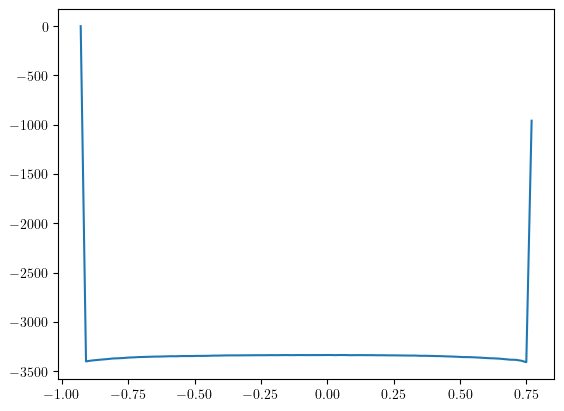

In [ ]:
mx = np.max(S)
S_sum = mx + np.log(np.sum(np.exp(S - mx)))
plt.plot((bins_center[S != 0]-SNet.M1)/(SNet.M3-SNet.M1),(S-S_sum)[S != 0])
print(S)

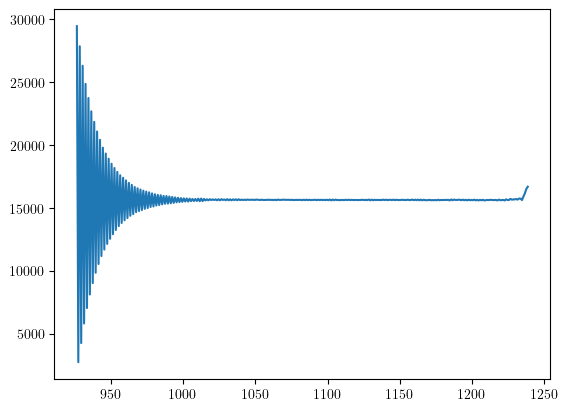

In [ ]:
data = [(i, j) for i, j in sorted(H_star.items())]
datax = [(bins_edge[i[0]] + bins_edge[i[0] + 1]) / 2 for i in data]
datay = [i[1] / (bins_edge[i[0] + 1] - bins_edge[i[0]]) for i in data]
plt.plot(datax, datay)

In [ ]:
A = ig_to_A(net)
SNet = MatSamp(A, False)
Strack = []
sample_cnt = 1000000
#SNet.trackCheckerboard = True
# SNet.trackMotif = True

mu_t = -1
std_t = 0.1

In [ ]:
beta = 0
total_iters = sample_cnt
pbar = tqdm(total=total_iters)
cnt = 0
back_cnt = 0

while cnt < sample_cnt:
    # swt = SNet.next("rand")

    # CBcur = SNet.count_checker()
    # pp = 1
    # if CBcur[0] == 0:
    #     pp = 0.5
    #     swt = find_random_checker(
    #         SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, False
    #     )
    # elif CBcur[1] == 0:
    #     pp = 0.5
    #     swt = find_random_checker(
    #         SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, True
    #     )
    # else:
    #     swt = find_random_checker(
    #         SNet.A, SNet.pc, SNet.nc, SNet.pc_rows, SNet.nc_rows, np.random.rand() > 0.5
    #     )  # SNet.find_random_checker()

    # rcur = SNet.assortativity_coeff()
    # SNet.switch(swt)
    # rnxt = SNet.assortativity_coeff()
    # CBnxt = SNet.count_checker()

    # propose_chance = np.random.rand()

    # # switch back
    # if (M2nxt - M2cur > 0 and propose_chance / pp > CBcur[0] / CBnxt[1]) or (
    #     M2nxt - M2cur < 0 and propose_chance / pp > CBcur[1] / CBnxt[0]
    # ):
    #     SNet.switch(swt)
    # else:
    swt = SNet.next("rand")

    rcur = SNet.assortativity_coeff()
    M2cur = SNet.M2
    SNet.switch(swt)
    rnxt = SNet.assortativity_coeff()
    M2nxt = SNet.M2

    chance = np.random.rand()

    curidx = np.searchsorted(bins_center, M2cur, side="right") - 1
    nxtidx = np.searchsorted(bins_center, M2nxt, side="right") - 1

    Scur = S[curidx] + (S[curidx + 1] - S[curidx]) * (
        M2cur - bins_center[curidx]
    ) / (bins_center[curidx + 1] - bins_center[curidx])

    Snxt = S[nxtidx] + (S[nxtidx + 1] - S[nxtidx]) * (M2nxt - bins_center[nxtidx]) / (
        bins_center[nxtidx + 1] - bins_center[nxtidx]
    )

    Ecur = 1 / 2 * ((rcur - mu_t) / std_t) ** 2 + Scur
    Enxt = 1 / 2 * ((rnxt - mu_t) / std_t) ** 2 + Snxt

    # switch back
    if np.log(chance) > Ecur-Enxt:
        SNet.switch(swt)

    # bin_idx = np.searchsorted(bins_edge, SNet.M2, side="right") - 1
    # S_new[bin_idx] += f / (bins_edge[bin_idx + 1] - bins_edge[bin_idx])
    Strack.append(rnxt)
    cnt += 1
    pbar.update(1)
print(np.mean(Strack))

  0%|          | 0/1000000 [00:00<?, ?it/s]

-0.8749870206676722


1


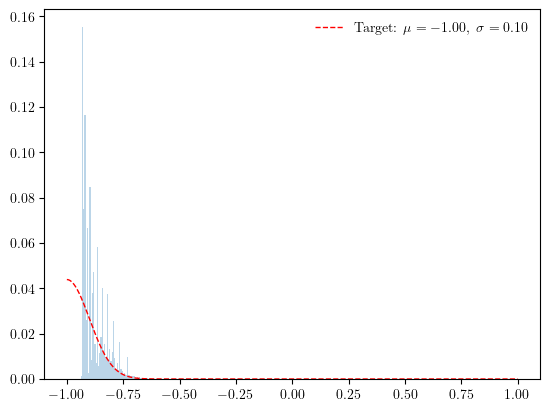

In [ ]:
from scipy.stats import norm, truncnorm
from scipy.optimize import fmin_slsqp


# print(len(Strack))
tau = 1
x = np.linspace(-1, 1, bin_cnt*10)
ct = 1#norm.cdf(max(Strack), mu_t, std_t)-norm.cdf(min(Strack), mu_t, std_t) # + 1 - norm.cdf(min(Strack), mu_t, std_t)
print(ct)
pt = norm.pdf(x, mu_t, std_t)
pt = pt / np.sum(pt)
plt.plot(
    x,
    pt*10/ct,
    "r--",
    linewidth=1,
    label=r"Target: $\mu={:.2f},~\sigma={:.2f}$".format(mu_t, std_t),
)


weights = np.ones_like(Strack[::tau]) / len(Strack[::tau])
count, bins, _ = plt.hist(
    Strack[::tau], bins=np.linspace(-1, 1, bin_cnt), weights=weights, alpha=0.3
)
#plt.ylim([0, max(count)])
#plt.xlim([min(Strack[::tau]), max(Strack[::tau])*1.1])
plt.legend(frameon=False)